In [1]:
import numpy as np
import pymust # To install it, use pip -e . install, orcopy the src/pymust folder to your project
import matplotlib.pyplot as plt
import scipy, scipy.io
import matplotlib, tqdm, tqdm.notebook


# Test simus - single scatterer

In [2]:

param = pymust.getparam('P4-2v')

nPoints = 5000
xs = np.random.rand(1,nPoints)*12e-2-6e-2
zs = np.random.rand(1,nPoints)*12e-2
idx = np.hypot(xs,zs-.05)<5e-2
xs = xs[np.logical_not(idx)].reshape((1, -1))
zs = zs[np.logical_not(idx)].reshape((1, -1))
RC = 3+np.random.rand(*xs.shape)  # reflection coefficients

xs = np.array([1e-2])
zs = np.array([0])
RC = np.array([1])

width = 60/180*np.pi; # width angle in rad
txdel = pymust.txdelay(param,0,width) # in s

RF,RFspectrum = pymust.simus(xs,zs,RC,txdel,param)
IQ = pymust.rf2iq(RF,param)

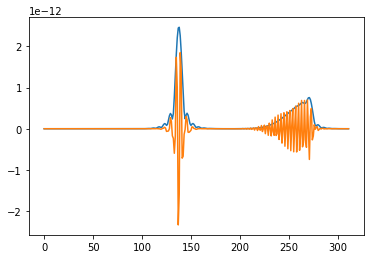

In [3]:
plt.plot(np.abs(IQ[:,10]))
plt.plot(RF[:,10])

# Compare with matlab
## Single scatterer example

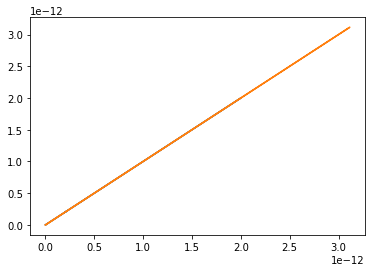

In [4]:
#Compare with matlab
d = scipy.io.loadmat('/Users/gbernardino/Desktop/rf.mat')
plt.plot(np.abs(d['RF'][:, 0]), np.abs(RF[:,0]))

IQ = pymust.rf2iq(RF.astype(float),param)
d = scipy.io.loadmat('/Users/gbernardino/Desktop/IQ.mat')
plt.plot(np.abs(d['IQ'][:, 30]), np.abs(IQ[:,30]))

## DAS matrix

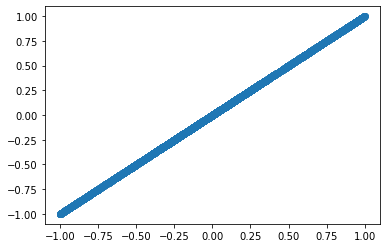

In [5]:
param = pymust.getparam('P4-2v')

x,z = pymust.impolgrid(np.array([32, 32]),
                          10e-2, 
                          np.pi/3,
                          param)
width = 60/180*np.pi; # width angle in rad

txdel = pymust.txdelay(param,0,width) # in s
param.fs = 4 * param.fc
Mdas = pymust.dasmtx(1j *np.array([256, param.Nelements]),x,z,param)
Mdas_full = np.array(Mdas.todense())
mdas_matlab = scipy.io.loadmat('/Users/gbernardino/Desktop/Mdas_full.mat')['Mdas_full']
np.sum(Mdas_full), np.sum(mdas_matlab)
plt.scatter(np.real(Mdas_full.flatten()).reshape(-1), np.real(mdas_matlab.flatten()).reshape(-1))

# Test disk 
Here I generate a rotating disk, I test simus, txdelay, dasmtx, rf2iq and bmode

In [6]:
def rotatePoints(x, y, x0, y0, theta):
    x = x - x0
    y = y - y0
    x1 = x * np.cos(theta) - y * np.sin(theta) + x0
    y1 = x * np.sin(theta) + y * np.cos(theta) + y0
    return x1, y1

In [7]:
param = pymust.getparam('P4-2v')
nPoints = 50000
xs = np.random.rand(1,nPoints)*12e-2-6e-2
zs = np.random.rand(1,nPoints)*12e-2

centerDisk = 0.05
idx = np.hypot(xs,zs-centerDisk)<2e-2 # First disk
idx2 = np.hypot(xs,zs-.035)< 5e-3 # Second disk

RC = np.random.rand(*xs.shape)  # reflection coefficients
# Add a second mmore reflecting 
RC[idx] += 1
RC[idx2] += 2


# Rotating disk velocity
rotation_frequency = .5
w = 2 * np.pi  * rotation_frequency#1 Hz = 2 pi rads
nreps = 5
param.PRP = 1e-3
for i in tqdm.notebook.tqdm(range(nreps)):
    options = pymust.utils.Options()
    options.dBThresh = -6

    xs[idx], zs[idx] = rotatePoints(xs[idx], zs[idx], 0, centerDisk,  i * w *  param.PRP)
    width = 60/180*np.pi; # width angle in rad
    txdel = pymust.txdelay(param,0,width) # in s
    RF, RF_spectrum = pymust.simus(xs,zs,RC,txdel,param, options)
    if i ==0:
        IQ = np.zeros([RF.shape[0], RF.shape[1], nreps], dtype = np.complex128)
    IQ[:, :, i] = pymust.rf2iq(RF,param)
    

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
x,z = pymust.impolgrid(np.array([256, 256]),
                          10e-2, 
                          np.pi/3,
                          param)
Mdas = pymust.dasmtx(IQ[:,:,0],x,z,param)
IQb = np.zeros((x.shape[0], x.shape[1], nreps), dtype = np.complex128)
for i in tqdm.notebook.tqdm(range(nreps)):
    IQb[:, :, i] = (Mdas@IQ[:,:,i].flatten(order = 'F')).reshape(x.shape, order = 'F')


  0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/ls/f__5k1dx5sl9qrl73_9lvrl80000gn/T/ipykernel_38754/2099971117.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(z, x , b,edgecolors='face', cmap = 'gray')


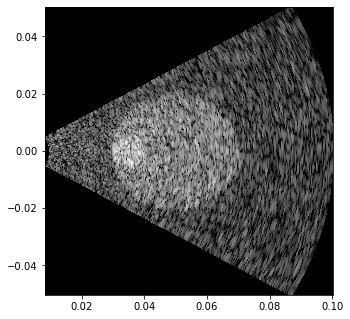

In [9]:
b = pymust.bmode(IQb[:,:,0])
fig = plt.figure(figsize=[5,5])
ax = fig.add_axes([0.15,0.15,0.8,0.8])
#fig.set_facecolor("black")
ax.pcolormesh(z, x , b,edgecolors='face', cmap = 'gray')
ax.set_facecolor('black')
#ec='face' to avoid annoying gridding in pdf
plt.savefig('carte_polar.png')


In [12]:
doppler_vel, doppler_var = pymust.iq2doppler(IQb,param)

In [13]:
isinstance(param, pymust.utils.Param)

True

In [20]:
np.max(doppler_var)

0.004050982230128295

/var/folders/ls/f__5k1dx5sl9qrl73_9lvrl80000gn/T/ipykernel_38754/1806030149.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(z, x , b,edgecolors='face', cmap = 'grey')


ValueError: 'grey' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

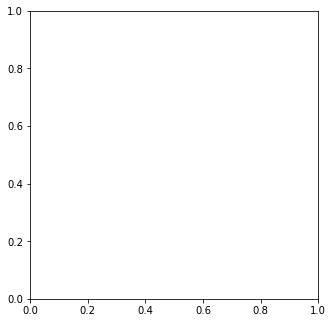

In [21]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_axes([0.15,0.15,0.8,0.8])
#fig.set_facecolor("black")
ax.pcolormesh(z, x , b,edgecolors='face', cmap = 'grey')

ax.pcolormesh(z, x , doppler_vel,edgecolors='face', cmap = pymust.getDopplerColorMap().cmap, alpha = doppler_var/np.max(doppler_var))
ax.set_facecolor('black')
#ec='face' to avoid annoying gridding in pdf
plt.savefig('carte_polar.png')


array([[[ 1.09861570e-02 +728.05646023j, -9.28617307e+00 +736.41731886j,
         -7.45948507e+00 +738.04780722j,  2.24674156e+01 +719.11387866j,
         -5.71815015e-01 +714.957493j  ],
        [-5.51795065e+02 +582.37534284j, -5.63754132e+02 +589.46156373j,
         -5.60986370e+02 +593.03690644j, -5.23843711e+02 +585.68539034j,
         -5.47588688e+02 +572.62818845j],
        [-1.02167295e+03 +195.63690654j, -1.03687536e+03 +200.23186368j,
         -1.03444895e+03 +207.09904418j, -9.95330637e+02 +213.23801955j,
         -1.01590843e+03 +191.07452063j],
        ...,
        [-7.86758408e+00+1073.31713243j,  2.79445468e+00+1064.49480083j,
          1.42576582e+01+1073.65818306j, -5.05296039e+00+1056.23258397j,
          1.17187834e+01+1078.37709033j],
        [-1.93462010e+02 +849.11356531j, -1.87157755e+02 +830.8903246j ,
         -1.71860138e+02 +829.22753212j, -1.92746677e+02 +824.47348227j,
         -1.70643593e+02 +840.87061509j],
        [-4.45893498e+02 +642.96973149j, -4.498